# Analysis of Stays of Removal Data

Code for undertaking statistical analysis of Federal Court stays of removal data

### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf

# set path to data 

#############################

# if you want to use deprecated_data, set the following to True, otherwise set to False

deprecated_data = True

###########################

if deprecated_data:
    parsed_file = 'output/DEPRECATED-ADA-stays_parsed_2012-22'
else:
    parsed_file ='output/stays_parsed_2012-22'

pd.set_option('display.max_colwidth', None)

### Prepare Tables for Publication

In [2]:
# load df_completion 
df_completion = pd.read_excel(parsed_file+'.xlsx')
print(df_completion.columns)

Index(['citation', 'year', 'city_filed', 'nature', 'RE_NO', 'DOCNO', 'DOC_DT',
       'category', 'type', 'outcome', 'judge', 'stay_of_removal',
       'notice_docno', 'notice_date', 'stay_outcome', 'stay_outcome_date',
       'stay_judge'],
      dtype='object')


In [3]:
# Filter cases to remove those without a stay order granting or denying stay

def prepare_df(df, print_yes=False):
    if print_yes: print('All cases screened in:', len(df))
    df_filtered=df[df['stay_of_removal']==True]
    if print_yes: print('Cases with stay of removal notice of motion:', len(df_filtered))
    df_filtered=df_filtered[df_filtered['stay_outcome'].isin(['granted', 'dismissed'])]
    if print_yes:
        print('Cases with an order granting or dismissing stay of removal:', len(df_filtered))
        print()
        print(df_filtered['stay_outcome'].value_counts())
        df_filtered.reset_index(drop=True, inplace=True)
    df_filtered['stay_outcome_date'] = pd.to_datetime(df_filtered['stay_outcome_date'], format='%Y-%m-%d') 
    df_filtered.rename(columns={'city_filed':'city'}, inplace=True) 
    df_filtered.rename(columns={'nature':'case_type'}, inplace=True)
     
    return df_filtered

df_filtered = prepare_df(df_completion, print_yes=True)

All cases screened in: 7045
Cases with stay of removal notice of motion: 6161
Cases with an order granting or dismissing stay of removal: 4717

stay_outcome
dismissed    3124
granted      1593
Name: count, dtype: int64


In [4]:
# group by year of decision

def group_by_year(df):
    years_df = df.groupby(df['stay_outcome_date'].dt.year)['stay_outcome'].value_counts().unstack()
    years_df.reset_index(inplace=True)
    years_df['stay_outcome_date']=years_df['stay_outcome_date'].astype(str)
    years_df.set_index('stay_outcome_date', inplace=True)
    years_df['total']=years_df['granted']+years_df['dismissed']
    years_df.loc['all years'] = years_df.sum(numeric_only=True)
    years_df['grant rate']=(100 * years_df['granted']/years_df['total']).round(1)
    years_df.reset_index(inplace=True)
    years_df.rename(columns={'stay_outcome_date':'year'}, inplace=True)
    return years_df

years_df = group_by_year(df_filtered)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(years_df.style.
    set_caption('Table 1: Federal Court stays of removal by year decided (2012-2022) (to Dec 1 in 2022)').
    format(precision=1, thousands=',').
    hide(axis='index')
    )

year,dismissed,granted,total,grant rate
2012,499,213,712,29.9
2013,369,146,515,28.3
2014,383,191,574,33.3
2015,305,187,492,38.0
2016,257,152,409,37.2
2017,229,123,352,34.9
2018,205,112,317,35.3
2019,379,224,603,37.1
2020,104,62,166,37.3
2021,187,89,276,32.2


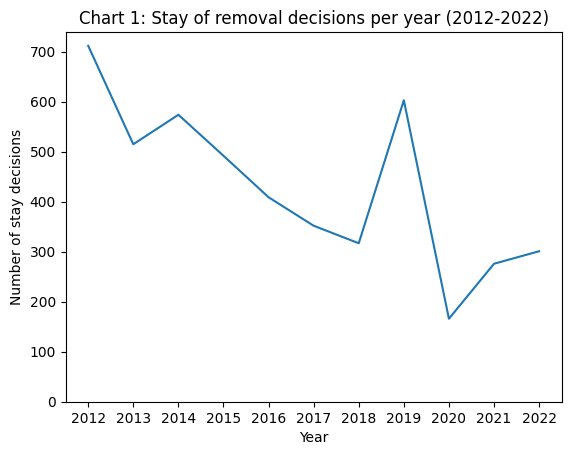

In [5]:
# plot number of stay of removal decisions per year
years_df.reset_index(inplace=True)
years_df.drop(years_df.tail(1).index,inplace=True)
plt.plot(years_df['year'], years_df['total'])
plt.xlabel('Year')
plt.ylabel('Number of stay decisions')
plt.title('Chart 1: Stay of removal decisions per year (2012-2022)')
plt.ylim(bottom=0)
plt.show()

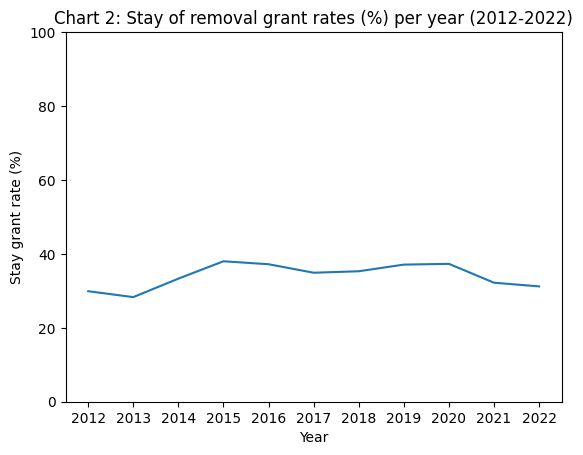

In [6]:
# plot grant rates per year
plt.plot(years_df['year'], years_df['grant rate'])
plt.xlabel('Year')
plt.ylabel('Stay grant rate (%)')
plt.title('Chart 2: Stay of removal grant rates (%) per year (2012-2022)')
plt.ylim(bottom=0)
plt.ylim(top=100)
plt.show()

In [7]:
# group by judges
def group_by_judges(df):
    judge_df = df.groupby('stay_judge')['stay_outcome'].value_counts().unstack()
    judge_df['dismissed']=judge_df['dismissed'].fillna(0).astype(int)
    judge_df['granted']=judge_df['granted'].fillna(0).astype(int)
    judge_df['total'] = judge_df['granted']+judge_df['dismissed']
    judge_df['grant rate']=(100 * judge_df['granted']/judge_df['total']).round(1)
    judge_df=judge_df.sort_values(by='grant rate', ascending=False)
    judge_df.loc['all judges'] = judge_df.sum(numeric_only=True).astype(int)
    judge_df.at['all judges', 'grant rate'] = (100 * judge_df.at['all judges', 'granted']/judge_df.at['all judges', 'total']).round(1)
    judge_df.reset_index(inplace=True)
    judge_df.rename(columns={'stay_judge':'judge'}, inplace=True)
    return judge_df

judge_df = group_by_judges(df_filtered)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(judge_df.style.
    set_caption('Table 2a: Federal Court stays of removal by judge (2012-2022) (to Dec 1 in 2022)').
    format(precision=1, thousands=',').
    hide(axis='index')
    )

judge,dismissed,granted,total,grant rate
Go,1,5,6,83.3
Campbell,16,61,77,79.2
O'Keefe,15,33,48,68.8
Sadrehashemi,2,4,6,66.7
Ahmed,22,39,61,63.9
Hansen,2,3,5,60.0
Norris,21,29,50,58.0
Hughes,28,34,62,54.8
Heneghan,111,133,244,54.5
O'Reilly,35,40,75,53.3


In [8]:
# group by judges, only those with 30+ cases
def limit_judges(judge_df, n_cases=30):
    judge_df=judge_df[judge_df['total']>=n_cases]
    return judge_df

judge_df = limit_judges(judge_df)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(judge_df.style.
    set_caption('Table 2: Federal Court stays of removal by judge, 30+ decisions only (2012-2022) (to Dec 1 in 2022)').
    format(precision=1, thousands=',').
    hide(axis='index')
    )

judge,dismissed,granted,total,grant rate
Campbell,16,61,77,79.2
O'Keefe,15,33,48,68.8
Ahmed,22,39,61,63.9
Norris,21,29,50,58.0
Hughes,28,34,62,54.8
Heneghan,111,133,244,54.5
O'Reilly,35,40,75,53.3
Harrington,28,31,59,52.5
Favel,27,27,54,50.0
Boswell,54,47,101,46.5


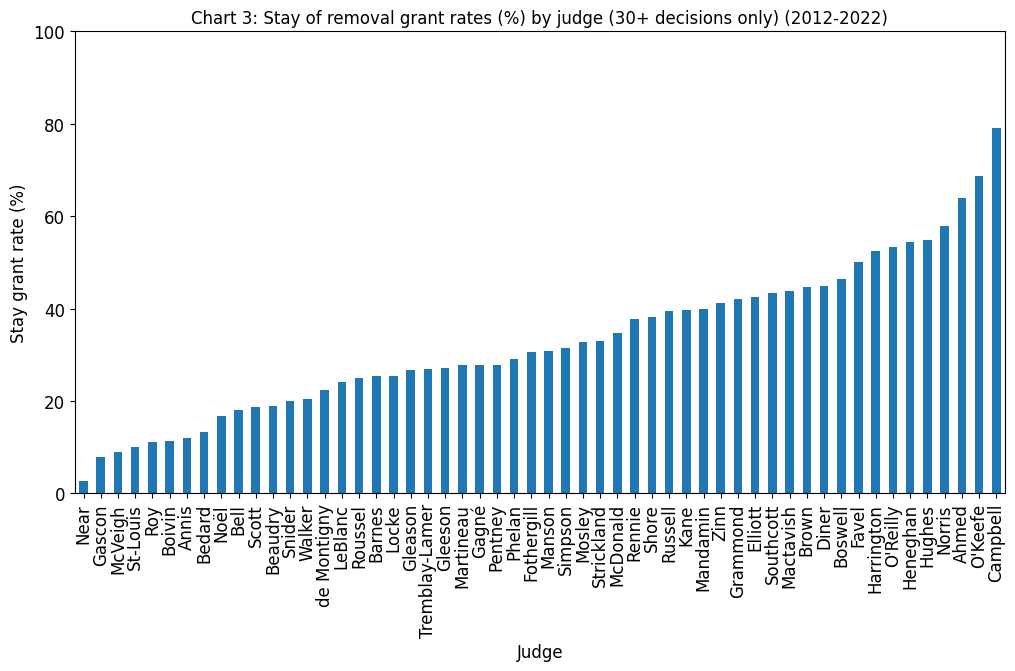

In [9]:
# plot grant rates per judge
judge_df.reset_index(inplace=True)
# remove the last row, which is the "all judges" row
judge_df.drop(judge_df.tail(1).index,inplace=True)
judge_df=judge_df.sort_values(by='grant rate', ascending=True)
judge_df.reset_index(inplace=True)
ax = judge_df[['judge','grant rate']].plot(kind='bar', title ='Chart 3: Stay of removal grant rates (%) by judge (30+ decisions only) (2012-2022)', figsize=(12, 6), legend=False, fontsize=12)
ax.set_xlabel('Judge', fontsize=12)
ax.set_ylabel('Stay grant rate (%)', fontsize=12)
ax.set_ylim(bottom=0)
ax.set_ylim(top=100)

# instead of showing the index value on the x-axis, use the "judge" column for the x-axis
ax.set_xticklabels(judge_df['judge'])


plt.show()

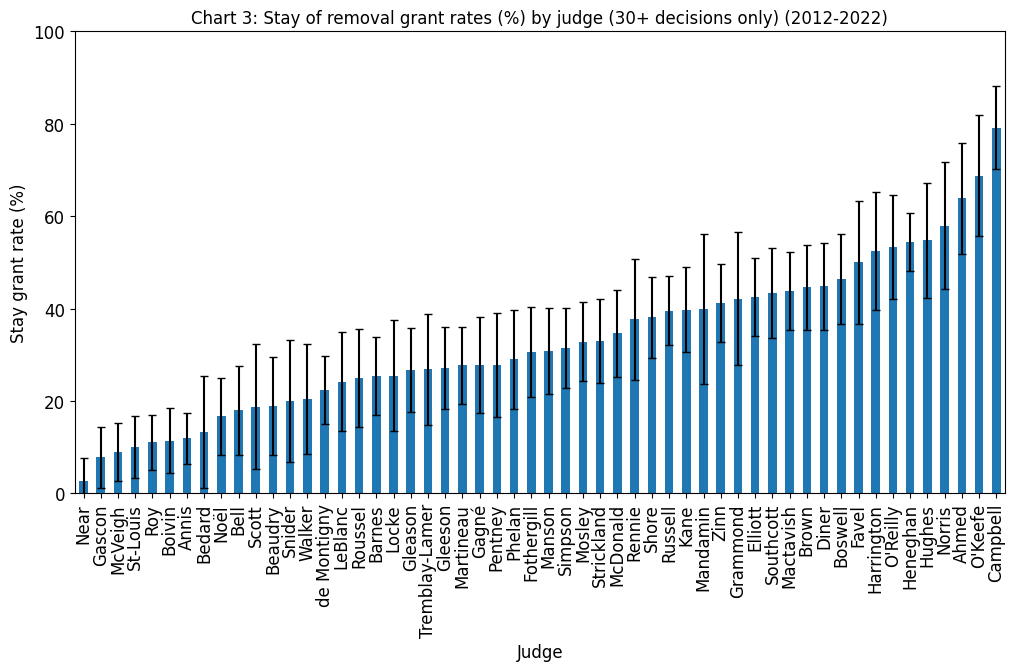

In [10]:
# same chart as above but with 95% confidence intervals

ax = judge_df[['judge','grant rate']].plot(kind='bar', title ='Chart 3: Stay of removal grant rates (%) by judge (30+ decisions only) (2012-2022)', figsize=(12, 6), legend=False, fontsize=12)
ax.set_xlabel('Judge', fontsize=12)
ax.set_ylabel('Stay grant rate (%)', fontsize=12)
ax.set_ylim(bottom=0)
ax.set_ylim(top=100)
ax.set_xticklabels(judge_df['judge'])

# add error bars 95%
judge_df['se']=1.96*np.sqrt(judge_df['grant rate']*(100-judge_df['grant rate'])/judge_df['total'])
ax.errorbar(x=judge_df.index, y=judge_df['grant rate'], yerr=judge_df['se'], fmt='none', ecolor='black', capsize=3)

plt.show()



In [11]:
# group by city, 30+ cases only
def group_by_city(df):
    city_df = df.groupby('city')['stay_outcome'].value_counts().unstack()
    city_df['dismissed']=city_df['dismissed'].fillna(0).astype(int)
    city_df['granted']=city_df['granted'].fillna(0).astype(int)
    city_df['total'] = city_df['granted']+city_df['dismissed']
    city_df['grant rate']=(100 * city_df['granted']/city_df['total']).round(1)
    city_df=city_df.sort_values(by='grant rate', ascending=True)
    city_df.loc['all cities'] = city_df.sum(numeric_only=True).astype(int)
    city_df.at['all cities', 'grant rate'] = (100 * city_df.at['all cities', 'granted']/city_df.at['all cities', 'total']).round(1)
    city_df=city_df[city_df['total']>=30]
    city_df.reset_index(inplace=True)
    return city_df

city_df = group_by_city(df_filtered)


with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(city_df.style.
    set_caption('Table 3: Federal Court stays of removal by city where judicial review filed, 30+ cases only (2012-2022*) * To Dec 1, 2022').
    format(precision=1, thousands=',').
    hide(axis='index')
    )
    


city,dismissed,granted,total,grant rate
Winnipeg,62,12,74,16.2
Montréal,641,149,790,18.9
Calgary,79,24,103,23.3
Edmonton,42,13,55,23.6
Vancouver,187,84,271,31.0
Ottawa,142,65,207,31.4
Toronto,"1,948","1,239","3,187",38.9
all cities,"3,124","1,593","4,717",33.8


In [12]:
# group by type, 30+ cases only
def group_by_type(df):
    type_df = df.groupby('case_type')['stay_outcome'].value_counts().unstack()
    type_df['dismissed']=type_df['dismissed'].fillna(0).astype(int)
    type_df['granted']=type_df['granted'].fillna(0).astype(int)
    type_df['total'] = type_df['granted']+type_df['dismissed']
    type_df['grant rate']=(100 * type_df['granted']/type_df['total']).round(1)
    type_df=type_df.sort_values(by='grant rate', ascending=True)
    type_df.loc['all types'] = type_df.sum(numeric_only=True).astype(int)
    type_df.at['all types', 'grant rate'] = (100 * type_df.at['all types', 'granted']/type_df.at['all types', 'total']).round(1)
    type_df=type_df[type_df['total']>=30]
    type_df.reset_index(inplace=True)
    type_df.rename(columns={'case_type':'case type'}, inplace=True)
    return type_df

type_df = group_by_type(df_filtered)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(type_df.style.
    set_caption('Table 4: Federal Court stays of removal by type of application filed, 30+ cases only (2012-2022*) * To Dec 1, 2022').
    format(precision=1, thousands=',').
    hide(axis='index')
    )
    


case type,dismissed,granted,total,grant rate
Imm - Appl. for leave & jud. review - IRB - Immigration Division,27,9,36,25.0
Imm - Appl. for leave & jud. review - Other Arising in Canada,"2,201","1,029","3,230",31.9
Imm - Appl. for leave & jud. review - IRB - Refugee Protection Div.,30,16,46,34.8
Imm - Appl. for leave & jud. review - Pre-removal risk assessment,712,420,"1,132",37.1
Imm - Appl. for leave & jud. review - IRB - Refugee,112,105,217,48.4
all types,"3,124","1,593","4,717",33.8


In [13]:
# Filter for specific years, cities, and case types  # NOTE: NEED TO SKIP THIS IF YOU WANT TO DO THE REGRESSION

# load df_completion 
df_completion = pd.read_excel(parsed_file+'.xlsx')
df_filtered = prepare_df(df_completion)

def specific_years_city_type(df, years, city, type):
    df = df[df['city'] == city]
    df = df[df['case_type'] == type]
    df = df[df['stay_outcome_date'].dt.year.astype(str).replace('.0', '').isin(years)]
    df = df[df['stay_outcome'].isin(['granted', 'dismissed'])]
    return df

years = ['2016','2017','2018', '2019', '2020']
city = 'Toronto'
type = 'Imm - Appl. for leave & jud. review - Other Arising in Canada'

df_specific = specific_years_city_type(df_filtered, years, city, type)

judge_df = group_by_judges(df_specific)
judge_df = limit_judges(judge_df)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(judge_df.style.
    set_caption('Table 5: Federal Court stays of removal by judge, filtered by year (2016-2020), city (Toronto), case type (Other arising in Canada), 30+ cases only').
    format(precision=1, thousands=',').
    hide(axis='index')
    )

judge,dismissed,granted,total,grant rate
Heneghan,27,36,63,57.1
Southcott,17,17,34,50.0
Russell,18,15,33,45.5
Boswell,30,23,53,43.4
Elliott,34,26,60,43.3
Diner,25,17,42,40.5
McDonald,34,17,51,33.3
Brown,22,10,32,31.2
Simpson,29,12,41,29.3
Strickland,28,11,39,28.2


In [14]:
# Run regression

# NOTE: Requires:
# ---- type_df
# ---- judge_df
# ---- city_df
# --- years_df
######## MAKE SURE THOSE ARE UP TO DATE #### TO DO THAT, RUN ALL THE CELLS ABOVE OTHER THAN THE ONE IMMEDIATELY ABOVE

# load df_completion 
df_completion = pd.read_excel(parsed_file+'.xlsx')

df = prepare_df(df_completion)
print(len(df))

years_df = group_by_year(df)
judge_df = group_by_judges(df)
judge_df = limit_judges(judge_df)
city_df = group_by_city(df)
type_df = group_by_type(df)

# Convert dates to years
df['stay_outcome_date'] = df['stay_outcome_date'].dt.year.astype(str).replace('.0', '')

# get mean grant rate for relevant year (excluding years with less than 30 cases)
df['year_mean'] = df['stay_outcome_date'].map(years_df.set_index('year')['grant rate'])
df=df[df['year_mean'].notna()]
print(len(df))

# get mean grant rate for relevant city (excluding cities with less than 30 cases)
df['city_mean'] = df['city'].map(city_df.set_index('city')['grant rate'])
df=df[df['city_mean'].notna()]
print(len(df))

# get mean grant rate for relevant case type (excluding types with less than 30 cases)
df['type_mean'] = df['case_type'].map(type_df.set_index('case type')['grant rate'])
df=df[df['type_mean'].notna()]
print(len(df))

# get mean grant rate for relevant judge (excluding judges with less than 30 cases)
df['judge_mean'] = df['stay_judge'].map(judge_df.set_index('judge')['grant rate'])
df=df[df['judge_mean'].notna()]
print(len(df))

# clean up the df
df = df[['citation','stay_outcome', 'stay_outcome_date', 'year_mean', 'city_mean', 'type_mean', 'judge_mean', 'case_type', 'city', 'stay_judge']]

# get new columns with names that help for regression
df['judge_mean_0_to_1'] = df['judge_mean']/100
df['judge_mean_in_percent'] = df['judge_mean']
df['type_mean_in_percent'] = df['type_mean']
df['year_mean_in_percent'] = df['year_mean']
df['city_mean_in_percent'] = df['city_mean']

# convert stay_outcome to 0/1
df['stay_outcome'] = df['stay_outcome'].replace('granted', 1)
df['stay_outcome'] = df['stay_outcome'].replace('dismissed', 0)

#print values of df.city
print(df['city'].value_counts())


# # Run regression

# Percent mean for judges
model = smf.logit(formula='stay_outcome ~ judge_mean_in_percent + C(case_type) + C(stay_outcome_date) +C(city)', data=df)
results = model.fit()
print(results.summary2())

# 0-1 mean for judges
model = smf.logit(formula='stay_outcome ~ judge_mean_0_to_1 + C(case_type) + C(stay_outcome_date) + C(city)', data=df)
results = model.fit()
print(results.summary2())

# Categorical all
model = smf.logit(formula='stay_outcome ~ C(stay_judge) + C(case_type) + C(stay_outcome_date) +C(city)', data=df)
results = model.fit()
print(results.summary2())

# Percent mean all
model = smf.logit(formula='stay_outcome ~ judge_mean_in_percent + type_mean_in_percent + year_mean_in_percent + city_mean_in_percent', data=df)
results = model.fit()
print(results.summary2())
#to get odds ratios
model_odds = pd.DataFrame(np.exp(results.params), columns= ['Odds Ratio'])
model_odds['z-value']= results.pvalues
model_odds[['2.5%', '97.5%']] = np.exp(results.conf_int())
print (model_odds)

4717
4717
4687
4632
4468
city
Toronto      3078
Montréal      754
Vancouver     233
Ottawa        198
Calgary        92
Winnipeg       67
Edmonton       46
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.578785
         Iterations 6
                                                          Results: Logit
Model:                                     Logit                                 Method:                                MLE        
Dependent Variable:                        stay_outcome                          Pseudo R-squared:                      0.100      
Date:                                      2024-02-23 17:11                      AIC:                                   5216.0204  
No. Observations:                          4468                                  BIC:                                   5356.9237  
Df Model:                                  21                                    Log-Likelihood:                   

In [15]:
# helper function for prettier regression

import re

def pretty_regression(results):
    # Retrieve the parameters, standard errors, p-values, and confidence intervals
    params = results.params
    standard_errors = results.bse
    pvalues = results.pvalues
    conf = np.exp(results.conf_int())

    # Calculate the Odds Ratios and the Wald statistic (Z-value)
    odds_ratios = np.exp(params)
    wald_stats = params / standard_errors

    # Function to reformat the variable names
    def reformat_variable_names(name):
        # This pattern looks for the strings that match "C(variable_name)[T.variable_value]"
        pattern = r'C\((.*?)\)\[T\.(.*?)\]'
        # Replace it with "variable_name: variable_value"
        new_name = re.sub(pattern, r'\1: \2', name)
        return new_name

    # Apply the function to the index of params to get new variable names
    new_index = [reformat_variable_names(name) for name in params.index]

    # Create the summary table with the new variable names
    summary_table = pd.DataFrame({
        "Variable": new_index,  # Use the new variable names
        "Coefficient": params.values.round(3),
        "Std Err": standard_errors.round(3),
        "Z": wald_stats.round(3),
        "P Value": pvalues.round(3),
        "Odds Ratio": odds_ratios.round(3),
        "95% CI Lower": conf[0].round(3),
        "95% CI Upper": conf[1].round(3),
    }).set_index('Variable')  # Set the new variable names as the index

    return (summary_table)


In [16]:
# Percent mean for judges
model = smf.logit(formula='stay_outcome ~ judge_mean_in_percent + C(case_type) + C(stay_outcome_date) +C(city)', data=df)
results = model.fit()
summary_table = pretty_regression(results)
summary_table

Optimization terminated successfully.
         Current function value: 0.578785
         Iterations 6


,Coefficient,Std Err,Z,P Value,Odds Ratio,95% CI Lower,95% CI Upper
Variable,,,,,,,
Intercept,-3.524,0.502,-7.026,0.000,0.029,0.011,0.079
case_type: Imm - Appl. for leave & jud. review - IRB - Refugee,0.942,0.438,2.152,0.031,2.564,1.088,6.045
case_type: Imm - Appl. for leave & jud. review - IRB - Refugee Protection Div.,0.207,0.538,0.385,0.700,1.230,0.429,3.529
case_type: Imm - Appl. for leave & jud. review - Other Arising in Canada,0.297,0.412,0.719,0.472,1.345,0.600,3.018
case_type: Imm - Appl. for leave & jud. review - Pre-removal risk assessment,0.559,0.416,1.344,0.179,1.749,0.774,3.953
stay_outcome_date: 2013,0.138,0.139,0.996,0.319,1.148,0.875,1.507
stay_outcome_date: 2014,0.342,0.133,2.579,0.010,1.408,1.086,1.827
stay_outcome_date: 2015,0.416,0.137,3.038,0.002,1.516,1.159,1.983
stay_outcome_date: 2016,0.479,0.142,3.378,0.001,1.614,1.222,2.130


In [17]:
# 0-1 mean for judges
model = smf.logit(formula='stay_outcome ~ judge_mean_0_to_1 + C(case_type) + C(stay_outcome_date) + C(city)', data=df)
results = model.fit()
summary_table = pretty_regression(results)
summary_table

Optimization terminated successfully.
         Current function value: 0.578785
         Iterations 6


,Coefficient,Std Err,Z,P Value,Odds Ratio,95% CI Lower,95% CI Upper
Variable,,,,,,,
Intercept,-3.524,0.502,-7.026,0.000,0.029,0.011,0.079
case_type: Imm - Appl. for leave & jud. review - IRB - Refugee,0.942,0.438,2.152,0.031,2.564,1.088,6.045
case_type: Imm - Appl. for leave & jud. review - IRB - Refugee Protection Div.,0.207,0.538,0.385,0.700,1.230,0.429,3.529
case_type: Imm - Appl. for leave & jud. review - Other Arising in Canada,0.297,0.412,0.719,0.472,1.345,0.600,3.018
case_type: Imm - Appl. for leave & jud. review - Pre-removal risk assessment,0.559,0.416,1.344,0.179,1.749,0.774,3.953
stay_outcome_date: 2013,0.138,0.139,0.996,0.319,1.148,0.875,1.507
stay_outcome_date: 2014,0.342,0.133,2.579,0.010,1.408,1.086,1.827
stay_outcome_date: 2015,0.416,0.137,3.038,0.002,1.516,1.159,1.983
stay_outcome_date: 2016,0.479,0.142,3.378,0.001,1.614,1.222,2.130


In [18]:
# Categorical all
model = smf.logit(formula='stay_outcome ~ C(stay_judge) + C(case_type) + C(stay_outcome_date) +C(city)', data=df)
results = model.fit()
summary_table = pretty_regression(results)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(summary_table)


Optimization terminated successfully.
         Current function value: 0.576005
         Iterations 8


,Coefficient,Std Err,Z,P Value,Odds Ratio,95% CI Lower,95% CI Upper
Variable,,,,,,,
Intercept,-0.828,0.563,-1.470,0.141,0.437,0.145,1.317
stay_judge: Annis,-2.690,0.390,-6.892,0.000,0.068,0.032,0.146
stay_judge: Barnes,-1.608,0.367,-4.385,0.000,0.200,0.098,0.411
stay_judge: Beaudry,-1.851,0.463,-3.998,0.000,0.157,0.063,0.389
stay_judge: Bedard,-1.950,0.622,-3.134,0.002,0.142,0.042,0.482
stay_judge: Bell,-2.005,0.438,-4.575,0.000,0.135,0.057,0.318
stay_judge: Boivin,-2.232,0.467,-4.781,0.000,0.107,0.043,0.268
stay_judge: Boswell,-1.034,0.347,-2.976,0.003,0.356,0.180,0.703
stay_judge: Brown,-0.936,0.340,-2.756,0.006,0.392,0.202,0.763


In [19]:
# Percent mean all
model = smf.logit(formula='stay_outcome ~ judge_mean_in_percent + type_mean_in_percent + year_mean_in_percent + city_mean_in_percent', data=df)
results = model.fit()
summary_table = pretty_regression(results)
summary_table

Optimization terminated successfully.
         Current function value: 0.580309
         Iterations 6


,Coefficient,Std Err,Z,P Value,Odds Ratio,95% CI Lower,95% CI Upper
Variable,,,,,,,
Intercept,-5.984,0.466,-12.848,0.0,0.003,0.001,0.006
judge_mean_in_percent,0.045,0.002,18.496,0.0,1.046,1.041,1.051
type_mean_in_percent,0.043,0.008,5.247,0.0,1.044,1.027,1.061
year_mean_in_percent,0.042,0.010,4.098,0.0,1.042,1.022,1.063
city_mean_in_percent,0.025,0.005,5.138,0.0,1.025,1.015,1.035


In [20]:
# run chi-square test for categorical variables: stay_outcome_date, city, case_type, stay_judge from df_merged

from scipy.stats import chi2_contingency

# chi-square test for categorical variables: stay_outcome_date, city, case_type, stay_judge from df_merged
# null hypothesis: there is no relationship between the two variables
# alternative hypothesis: there is a relationship between the two variables
# if p-value is less than 0.05, reject the null hypothesis
# if p-value is greater than 0.05, fail to reject the null hypothesis

# stay_outcome_date
observed = pd.crosstab(df['stay_outcome_date'], df['stay_outcome'])
chi2, p, dof, expected = chi2_contingency(observed)
print('stay_outcome_date')
print('chi2: ', chi2)
print('p: ', p)
print('dof: ', dof)
#print('expected: ', expected)
print('')

# city
observed = pd.crosstab(df['city'], df['stay_outcome'])
chi2, p, dof, expected = chi2_contingency(observed)
print('city')
print('chi2: ', chi2)
print('p: ', p)
print('dof: ', dof)
#print('expected: ', expected)
print('')

# case_type
observed = pd.crosstab(df['case_type'], df['stay_outcome'])
chi2, p, dof, expected = chi2_contingency(observed)
print('case_type')
print('chi2: ', chi2)
print('p: ', p)
print('dof: ', dof)
#print('expected: ', expected)
print('')

# stay_judge
observed = pd.crosstab(df['stay_judge'], df['stay_outcome'])
chi2, p, dof, expected = chi2_contingency(observed)
print('stay_judge')
print('chi2: ', chi2)
print('p: ', p)
print('dof: ', dof)
#print('expected: ', expected)
print('')



stay_outcome_date
chi2:  25.823115271428378
p:  0.003985512264448966
dof:  10

city
chi2:  122.08704436348393
p:  5.9375989563758066e-24
dof:  6

case_type
chi2:  29.219260580810875
p:  7.055223875281909e-06
dof:  4

stay_judge
chi2:  468.7764718883175
p:  6.216871977399401e-68
dof:  53



In [21]:
# group by judges
judge_df = df_filtered.groupby('stay_judge')['stay_outcome'].value_counts().unstack()
judge_df['dismissed']=judge_df['dismissed'].fillna(0).astype(int)
judge_df['granted']=judge_df['granted'].fillna(0).astype(int)
judge_df['total'] = judge_df['granted']+judge_df['dismissed']
judge_df['grant rate']=(100 * judge_df['granted']/judge_df['total']).round(1)
judge_df=judge_df.sort_values(by='grant rate', ascending=False)
judge_df.reset_index(inplace=True)
judge_df.rename(columns={'stay_judge':'judge'}, inplace=True)
judge_df=judge_df[judge_df['total']>=30]

# rename col "grant rate" to "stay grant rate"
judge_df.rename(columns={'grant rate':'stay grant rate'}, inplace=True)

#keep only the judge and grant rate columns
judge_df=judge_df[['judge', 'stay grant rate']]

# reset index
judge_df.reset_index(inplace=True)

judge_df

stay_outcome,index,judge,stay grant rate
0,1,Campbell,79.2
1,2,O'Keefe,68.8
2,4,Ahmed,63.9
3,6,Norris,58.0
4,7,Hughes,54.8
5,8,Heneghan,54.5
6,9,O'Reilly,53.3
7,10,Harrington,52.5
8,11,Favel,50.0
9,12,Boswell,46.5


In [22]:
# df luck read from TABLE3-LUCK2.xlsx
df_luck = pd.read_excel('TABLE3-LUCK2.xlsx')
df_luck

# keep only "Leave Judge" and "Leave Grant Rate (%)"
df_luck = df_luck[['Leave Judge', 'Leave Grant Rate (%)']]

# rename columns "judge" and "leave_rate"
df_luck.rename(columns={'Leave Judge':'judge', 'Leave Grant Rate (%)':'leave grant rate'}, inplace=True)
df_luck

,judge,leave grant rate
0,Mandamin,45.614035
1,Boswell,38.333333
2,O'Keefe,39.175258
3,Russell,41.958042
4,Elliott,39.473684
5,Heneghan,49.200000
6,Southcott,33.333333
7,Strickland,33.548387
8,Manson,31.067961
9,Zinn,31.724138


In [23]:
# merge df_luck with judge_df on judge, keeping only rows where there is a match (don't include both indexes)
df_judge_and_luck = pd.merge(judge_df, df_luck, on='judge', how='inner')

# remove second the dual indexes
df_judge_and_luck.reset_index(inplace=True)
df_judge_and_luck.drop(columns=['index', 'level_0'], inplace=True)

df_judge_and_luck

,judge,stay grant rate,leave grant rate
0,O'Keefe,68.8,39.175258
1,Hughes,54.8,12.977099
2,Heneghan,54.5,49.200000
3,O'Reilly,53.3,26.704545
4,Harrington,52.5,12.355212
5,Boswell,46.5,38.333333
6,Diner,44.8,22.641509
7,Brown,44.6,27.027027
8,Mactavish,43.9,18.117647
9,Southcott,43.4,33.333333


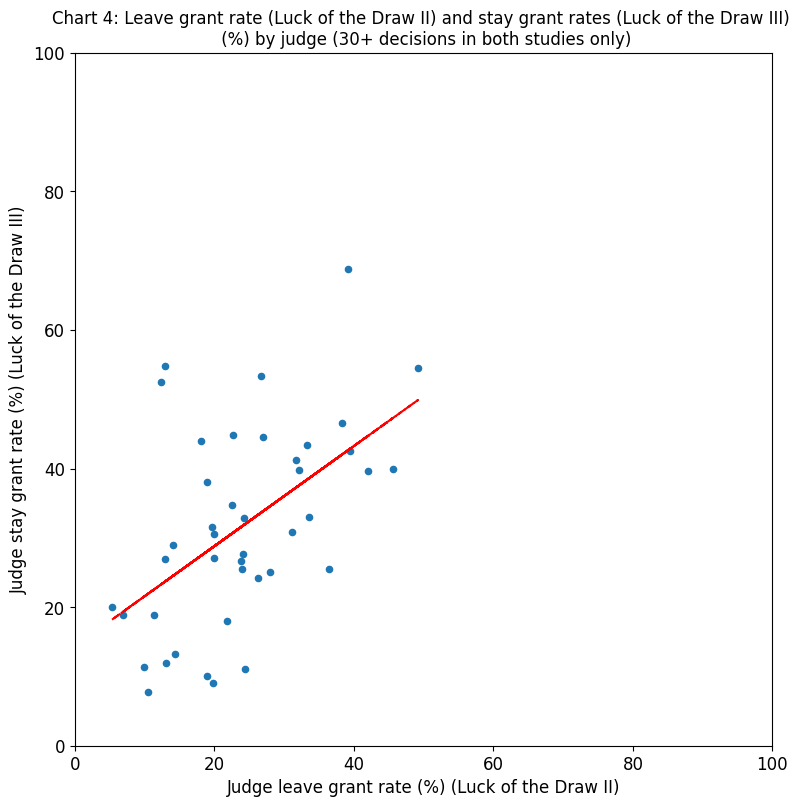

In [24]:
# from df_judge_and_luck make a plot chart with "leave grant rate" on the x-axis and "stay grant rate" on the y-axis
# add a trendline

# plot grant rates per judge
ax = df_judge_and_luck.plot.scatter(x='leave grant rate', y='stay grant rate', title='Chart 4: Leave grant rate (Luck of the Draw II) and stay grant rates (Luck of the Draw III) \n (%) by judge (30+ decisions in both studies only)', figsize=(9, 9), legend=False, fontsize=12)
ax.set_xlabel('Judge leave grant rate (%) (Luck of the Draw II)', fontsize=12)
ax.set_ylabel('Judge stay grant rate (%) (Luck of the Draw III)', fontsize=12)
ax.set_ylim(bottom=0)
ax.set_ylim(top=100)
ax.set_xlim(left=0)
ax.set_xlim(right=100)
#ax.set_aspect('equal', adjustable='box')
# add a trendline
z = np.polyfit(df_judge_and_luck['leave grant rate'], df_judge_and_luck['stay grant rate'], 1)
p = np.poly1d(z)
plt.plot(df_judge_and_luck['leave grant rate'],p(df_judge_and_luck['leave grant rate']),"r--")
plt.show()


### NOTES

DATES

Was getting error on dates. Fixed using Jacob's code for old parsing. Will need to integrate similar changes into other processes -- or alternatively could consider doing this in the process to create the parquet files to save on duplicated code.

SPEED

Could speed up substantially by (1) running in parallel or (especially) (2) by batching.
For (1) could use dask dataframes, but would likely exceed OpenAI API rate-limiting. Not
sure if there is a way to limit number of workers. Alternatively, could iterate over the
df and use dask delayed, which can specify the number of workers. Better would be to try
(2) but would need some additional architecture.

PROGRESS

Could add a progress bar for applying the model.

VERIFICATION

I compared the data for IMM-x-2020 with the data from PAT who was looking at the 2020 CanLII
stay cases. My process caught each of the applications in his dataset, so it is at least that
inclusive. 

I informally checked the stay of removal True/False column, and it is working really well. I would say 98.5% accuracy, and the mistakes are not unreasonable, errors involved typos (IMM-104-20), informal requests
(IMM-1638-20 & IMM-2826-20) and notices dealing with multiple types of motions at the same time
(IMM-5691-20). One thing to keep an eye on, I did see a hallucination (IMM-2826-20 invented a 
motion doc # for the hearing docket entry). Will see when I apply cross-references whether this
is common.

I had a research assistant review the output on 200 dockets (and she also identified the ones that are in French and I reviewed those myself). Out of 200 cases there were errors in 2 cases. Both of those times the errors involved failing to identify the cases as involving a stay of removal because of unusual ways of recording the notice of motion. There were no errors in parsing the data for the cases that were identified as involving stays of removal. That is a 99% accuracy rate, which is really good.

ERRORS re: Informal requests

A small number of motions for stays of removal don't have notices of motions, and instead proceed
with an informal request that takes a wide variety of forms (letters, communications, etc). These are 
not caught by the system, which relies on notices of motions (the problem is that often other docket
entries are inconclusive about the type of motion (e.g. "motion doc 4", or "stay of execution"), so 
we can't rely on other docket entries -- which means if we want to catch these, we probably need to
run most docket entries through GPT, which becomes more expensive. My feeling is that we can live
with missing these instances

ERRORS re: (Final Decision)

A small number of dockets have the stay decision included in a docket entry that has the (Final Decision)
marker, which are excluded from our models. This is rare, and I don't think it is worth trying to catch

HEARTING OUTCOMES:

One possible way to improve the coding would be to look at hearing outcomes. We can pretty reliably link
the hearing with the motion (because hearing docket entries almost always refer to the relevant notice
docket entry), and in cases where we haven't detected an order we could look at the hearing entry to 
see whether it includes an outcome. But in most cases the outcome is reserved (maybe 70%), so it would
only help in a small proportion of cases, and we are not missing outcomes very often anyway, so I am 
inclined not to try to do this.

REVISING INFRASTRUCTURE FOR UPDATING

If we want to run this periodically and to update when we get revised dockets without having to pay 
to reapply the models to everything, we could collect the name of the model applied, and a timestamp 
of when the model is applied, then load that, and before sending to GPT3, check whether we already
have a completion on that identical docket entry using the same model that we want to apply, and if
yes, just grab that rather than sending to GPT3. 





In [25]:
# # NOTE THIS WAS FOR SHARING TO DOUBLE CHECK STATS, NOT FOR ANALYSIS

# import pandas as pd
# import numpy as np
# import statsmodels.formula.api as smf


# # Load df_merged from excel
# df_merged = pd.read_excel('df_merged.xlsx')

# # Run regression, stay_outcome as dependent variable (1 granted, 0 dismissed)

# # Percent mean for judges, categorical for other variables
# model = smf.logit(formula='stay_outcome ~ judge_mean_in_percent + C(case_type) + C(stay_outcome_date) +C(city)', data=df_merged)
# results = model.fit()
# print(results.summary())

# # 0-1 mean for judges, categorical for other variables
# model = smf.logit(formula='stay_outcome ~ judge_mean_0_to_1 + C(case_type) + C(stay_outcome_date) + C(city)', data=df_merged)
# results = model.fit()
# print(results.summary())

# # Categorical all variables
# model = smf.logit(formula='stay_outcome ~ C(stay_judge) + C(case_type) + C(stay_outcome_date) +C(city)', data=df_merged)
# results = model.fit()
# print(results.summary())

# # Percent mean all variables
# model = smf.logit(formula='stay_outcome ~ judge_mean_in_percent + type_mean_in_percent + year_mean_in_percent + city_mean_in_percent', data=df_merged)
# results = model.fit()
# print(results.summary())

# # Get odds ratios for final model
# model_odds = pd.DataFrame(np.exp(results.params), columns= ['Odds Ratio'])
# model_odds['z-value']= results.pvalues
# model_odds[['2.5%', '97.5%']] = np.exp(results.conf_int())
# print (model_odds)


